# **Analítica de texto con redes recurrentes**

Ahora veremos cómo construir una red neuronal para hacer analítica de sentimiento en textos. Tomaremos un dataset de textos de críticas de películas de usuarios de IMDB, y entrenaremos una red para que aprenda a estimar a partir del texto de la revisión si la puntuación dada por el usuario fue buena, o si fue mala.

Empezaremos importando las librerías que vamos a utilizar:

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.utils import plot_model, pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from tensorflow.keras.preprocessing.text import Tokenizer
from matplotlib.ticker import MaxNLocator
import bokeh.plotting as bp
from bokeh.models import HoverTool, LabelSet
from bokeh.models import ColumnDataSource
from sklearn.decomposition import PCA

Ahora descargamos el dataset:

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  40.2M      0  0:00:01  0:00:01 --:--:-- 40.2M


In [3]:
print(os.listdir("aclImdb"))

['test', 'train', 'imdb.vocab', 'README', 'imdbEr.txt']


In [4]:
print(os.listdir("aclImdb/train"))

['neg', 'unsup', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_unsup.txt', 'urls_pos.txt', 'pos']


In [5]:
print(os.listdir("aclImdb/test"))

['neg', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'pos']


In [6]:
print(sorted(glob("./aclImdb/train/pos/*txt"))[:5])

['./aclImdb/train/pos/0_9.txt', './aclImdb/train/pos/10000_8.txt', './aclImdb/train/pos/10001_10.txt', './aclImdb/train/pos/10002_7.txt', './aclImdb/train/pos/10003_8.txt']


Como podemos ver hay dos carpetas, una de training y otra de test.
Por construcción, las críticas de test corresponden a películas diferentes que las de training, por lo que el accuracy en test nos va a indicar la calidad del sistema, una vez entrenado, en películas nuevas.
En cada carpeta de training y test hay a su vez dos subcarpetas: una con críticas positivas (subcarpeta “pos”), y otra con críticas negativas (subcarpeta “neg”).

Ahora leemos cada una de las críticas:

In [7]:
def lee_review(ruta):
    with open(ruta, "r") as f:
        texto = f.read()
    return texto

In [8]:
train_pos = [lee_review(x) for x in
             sorted(glob("./aclImdb/train/pos/*txt"))]
train_neg = [lee_review(x) for x in
             sorted(glob("./aclImdb/train/neg/*txt"))]
test_pos = [lee_review(x) for x in
            sorted(glob("./aclImdb/test/pos/*txt"))]
test_neg = [lee_review(x) for x in
            sorted(glob("./aclImdb/test/neg/*txt"))]

print(len(train_pos), len(train_neg), len(test_pos), len(test_neg))

12500 12500 12500 12500


Vemos que hay 25000 ejemplos en training y 25000 en test, con igual número de positivos que de negativos.

Ahora concatenamos train_pos con train_neg para formar una única lista “train” con todos los ejemplos de training, y construimos una lista de etiquetas para training con 12500 unos (vamos a codificar la clase positiva con 1) seguidos de 12500 ceros (vamos a codificar la clase negativa con 0).
Hacemos lo mismo para test:

In [9]:
train = train_pos + train_neg
y_train = np.array(len(train_pos)*[1] + len(train_neg)*[0])

test = test_pos + test_neg
y_test = np.array(len(test_pos)*[1] + len(test_neg)*[0])

Ahora, si mostramos uno de las críticas de training:

In [10]:
print(train[2137])

GREAT movie and the family will love it!! If kids are bored one day just pop the tape in and you'll be so glad you did!!!<br /><br />~~~Rube<br /><br />i luv raven-s!


Observamos la aparición de “\<br />”. Esto es un comando html para marcar “salto de línea” (los reviews han sido obtenidos directamente del código html de la crítica en la página web de IMDB).
Normalizamos a continuación los textos pasándolos a minúscula y eliminando este comando:

In [11]:
def normaliza(x):
    return x.lower().replace("<br />", " ")

In [12]:
train = [normaliza(x) for x in train]
test = [normaliza(x) for x in test]

In [13]:
print(train[2137])

great movie and the family will love it!! if kids are bored one day just pop the tape in and you'll be so glad you did!!!  ~~~rube  i luv raven-s!


Lo siguiente es tokenizar los textos. Es decir, descomponer cada texto del dataset en palabras individuales, e identificarlas. Para ello asignaremos a cada posible palabra un identificador entero, y codificaremos cada texto por una secuencia de estos identificadores.
En una colección de textos puede haber un número enorme de palabras únicas si consideramos, aparte de las palabras básicas, nombres propios, abreviaciones, erratas, etc.
Por tanto, lo primero que definiremos es un número máximo de palabras a codificar (en nuestro ejemplo, 5000).
Esto hará que solo se codifiquen las 5000 palabras más frecuentes:

In [14]:
top_words = 5000
tk = Tokenizer(oov_token="(oov)", num_words=5000)

tk.fit_on_texts(train)

Lo que hemos conseguido mediante este código es detectar las 4998 palabras más frecuentes (ahora veremos por qué este número y no 5000), y asignarle a cada una de ellas un entero.
El identificador 0 se reserva para “ausencia de palabra”, que como veremos es necesario para normalizar la longitud en número de palabras de los textos.
Por outra parte el identificador 1 se reserva para “palabra fuera de vocabulario” (“out of vocabulary”, “oov”), de tal forma que a todas las palabras infrecuentes les asignaremos este código.

A continuación tokenizamos cada texto del dataset, calculando la secuencia de índices correspondiente:

In [15]:
X_train = tk.texts_to_sequences(train)
X_test = tk.texts_to_sequences(test)

Comparemos ahora un texto original ya pasado a minúscula y sin br con su secuencia de identificadores correspondiente:

In [16]:
print(train[2786])

as usual, sean connery does a great job. lawrence fishburn is good, but i have a hard time not seeing him as ike turner.


In [17]:
print(X_train[2786])

[14, 641, 2050, 1, 124, 4, 84, 289, 4221, 1, 7, 49, 18, 10, 25, 4, 251, 55, 21, 316, 87, 14, 1, 3785]


Observamos por ejemplo que el código 14 corresponde a “as” y el 641 a “usual”.
Si ahora recuperamos el texto a partir de esos índices:

In [18]:
print(tk.sequences_to_texts(X_train[2786:2787]))

['as usual sean (oov) does a great job lawrence (oov) is good but i have a hard time not seeing him as (oov) turner']


Vemos que hay algunas palabras que no se han recuperado (“connery”, “fishburn”, “ike”) al ser palabras poco frecuentes en el dataset a las que se les ha asociado el código 1 (fuera de vocabulario, oov).

En general siempre “perderemos” palabras en nuestra codificación.
El número de tokens a codificar depende de la complejidad del dataset y de la riqueza de palabras que sea necesaria para solucionar el problema.
Por tanto, constituye un hiperparámetro que ajustar, y cuanto más bajo sea mejor (la complejidad de la implementación será menor).

Ahora estudiaremos las estadísticas de las longitudes de los textos:

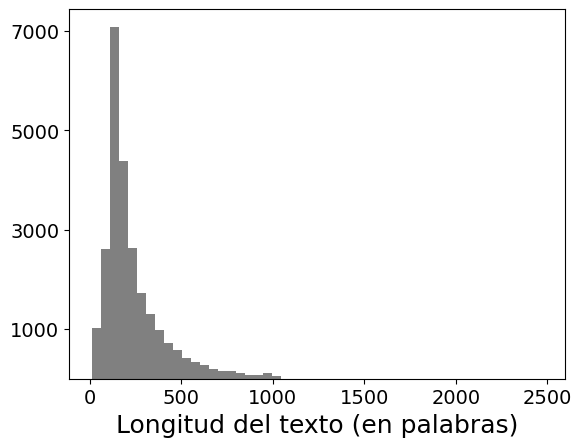

In [19]:
longs = [len(x) for x in X_train]
plt.hist(longs, bins=50, color="gray")
plt.xlabel("Longitud del texto (en palabras)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(range(1000, 8000, 2000), fontsize=14);

In [20]:
print(np.median(longs))

174.0


Vemos que aunque la mediana es 174 palabras hay bastante variabilidad.
En nuestra implementación tendremos que normalizar el tamaño de los textos (hacer que todos tengan igual longitud). Tendremos que elegir una longitud L a la que normalizar, de tal forma que las secuencias con menos de L elementos se rellenarán por la izquierda con ceros (recordemos que 0 es el identificador para “ausencia de palabra”) hasta llegar a L, y en las secuencias con más de L elementos se tomarán solo los L primeros.

Probaremos con un tamaño de L=250 para simplificar la carga computacional.
La idea es que aunque cortemos algunos reviews puede estar claro con las 250 primeras palabras si la crítica es positiva o negativa.

In [21]:
max_review_length = 250
X_train_pad = pad_sequences(X_train,
                            maxlen=max_review_length)
X_test_pad = pad_sequences(X_test,
                           maxlen=max_review_length)
print(X_train_pad.shape)

(25000, 250)


Vemos que efectivamente todas las secuencias han sido normalizadas a longitud 250.

Es el momento de definir nuestra red neuronal.
Utilizaremos un tamaño de embedding de 2.
Este tamaño suele ser mucho mayor para poder capturar todas las sutilezas del vocabulario, pero veremos que en este caso obtenemos un buen rendimiento con este tamaño reducido.

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

model = keras.Sequential([
    layers.Embedding(input_dim=top_words, output_dim=2,
                     input_length=max_review_length,
                     embeddings_regularizer=l2(l=0.01)),
    layers.Dropout(rate=0.5),
    layers.LSTM(units=5),
    layers.Dense(units=1, activation="sigmoid")
])

In [23]:
model.compile(loss="binary_crossentropy",
              optimizer="adam", metrics="accuracy")

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 2)            10000     
                                                                 
 dropout (Dropout)           (None, 250, 2)            0         
                                                                 
 lstm (LSTM)                 (None, 5)                 160       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 10,166
Trainable params: 10,166
Non-trainable params: 0
_________________________________________________________________


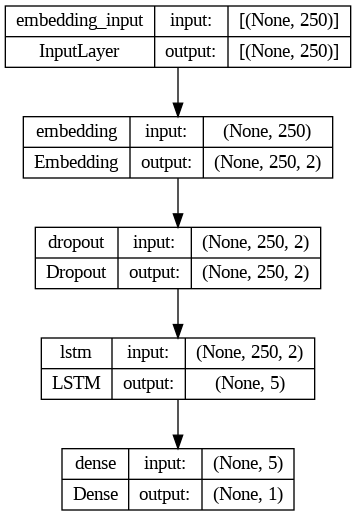

In [25]:
plot_model(model, "esquema.png", show_shapes=True)

Ahora reservamos un 30% de training para validación:

In [26]:
aux = train_test_split(X_train_pad, y_train, test_size=0.3,
                       random_state=1, stratify=y_train)
X_tr_pad, X_va_pad, y_tr, y_va = aux

In [27]:
print(X_tr_pad.shape, y_tr.shape)
print(X_va_pad.shape, y_va.shape)

(17500, 250) (17500,)
(7500, 250) (7500,)


Y entrenamos el modelo:

In [28]:
lista_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

historia = model.fit(X_tr_pad, y_tr,
                     epochs=40, batch_size=512,
                     callbacks=lista_callbacks,
                     validation_data=(X_va_pad, y_va))

Epoch 1/40
35/35 [==============================] - 9s 162ms/step - loss: 0.7262 - accuracy: 0.5022 - val_loss: 0.6978 - val_accuracy: 0.5337
Epoch 2/40
35/35 [==============================] - 6s 179ms/step - loss: 0.6941 - accuracy: 0.5524 - val_loss: 0.6926 - val_accuracy: 0.6181
Epoch 3/40
35/35 [==============================] - 5s 142ms/step - loss: 0.6921 - accuracy: 0.6074 - val_loss: 0.6910 - val_accuracy: 0.6484
Epoch 4/40
35/35 [==============================] - 6s 161ms/step - loss: 0.6829 - accuracy: 0.6093 - val_loss: 0.6587 - val_accuracy: 0.6641
Epoch 5/40
35/35 [==============================] - 6s 160ms/step - loss: 0.6392 - accuracy: 0.6985 - val_loss: 0.6120 - val_accuracy: 0.7285
Epoch 6/40
35/35 [==============================] - 5s 142ms/step - loss: 0.6147 - accuracy: 0.7402 - val_loss: 0.5837 - val_accuracy: 0.7947
Epoch 7/40
35/35 [==============================] - 6s 177ms/step - loss: 0.5906 - accuracy: 0.7626 - val_loss: 0.5694 - val_accuracy: 0.7732
Epoch 

Mostramos la evolución en el entrenamiento:

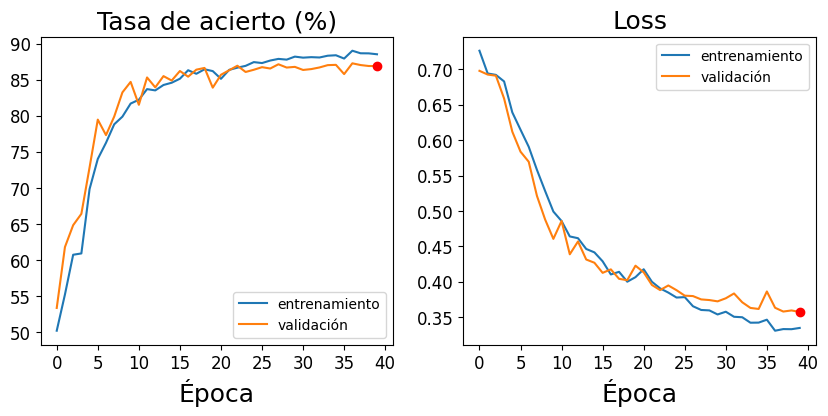

In [29]:
f = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
h = historia.history
e = np.argmin(h["val_loss"]) # mejor época
plt.plot(100*np.array(h["accuracy"]),
         label="entrenamiento")
plt.plot(100*np.array(h["val_accuracy"]),
         label="validación")
plt.plot(e, 100*h["val_accuracy"][e], "or")
plt.title("Tasa de acierto (%)", fontsize=18)
plt.xlabel("Época", fontsize=18)
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.legend()
f.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplot(1,2,2)
plt.plot(h["loss"], label="entrenamiento")
plt.plot(h["val_loss"], label="validación")
plt.plot(e, h["val_loss"][e], "or")
plt.title("Loss", fontsize=18)
plt.xlabel("Época", fontsize=18)
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.legend()
f.gca().xaxis.set_major_locator(MaxNLocator(integer=True));

Recuperamos de fichero la mejor configuración en validación y calculamos su porcentaje de acierto en training, validación y test:

In [30]:
model = keras.models.load_model("best_model.keras")

scores_tr = model.evaluate(X_tr_pad, y_tr,
                           return_dict=True)
scores_va = model.evaluate(X_va_pad, y_va,
                           return_dict=True)
scores_te = model.evaluate(X_test_pad, y_test,
                           return_dict=True)

print(100*scores_tr["accuracy"])
print(100*scores_va["accuracy"])
print(100*scores_te["accuracy"])

782/782 [==============================] - 13s 17ms/step - loss: 0.3678 - accuracy: 0.8650
92.60571599006653
86.89333200454712
86.50000095367432


Ahora analizaremos los embeddings.
A cada palabra se le asocia un vector de embedding de 2 dimensiones.
En conjunto, tenemos lo que se denomina “nube de palabras”.
Si la dibujamos obtenemos:

In [31]:
pca = PCA(n_components=2)
embeddings = model.layers[0].embeddings.numpy()
words_pca = pca.fit_transform(embeddings)
bp.output_notebook()
p = bp.figure(plot_width=700, plot_height=600,
              title="Nube de palabras",
              x_axis_label="Componente principal 1",
              y_axis_label="Componente principal 2")
p.title.text_font_size="16pt"
p.xaxis.axis_label_text_font_style="normal"
p.xaxis.axis_label_text_font_size="16pt"
p.yaxis.axis_label_text_font_style="normal"
p.yaxis.axis_label_text_font_size="16pt"

n_words = embeddings.shape[0]
aux = ColumnDataSource(
    {"componente1":words_pca[:,0],
     "componente2":words_pca[:,1],
     "words":["(padding)"]+[tk.index_word[i]
                            for i in range(1,n_words)]})
p.scatter(source=aux, x="componente1", y="componente2",
          color="black")
labels_p = LabelSet(source=aux, x="componente1",
                    y="componente2",
                    text="words", level="glyph",
                    x_offset=5, y_offset=5,
                    render_mode="canvas",
                    text_color="black",
                    text_font_size="10pt")
p.add_layout(labels_p)
hover = p.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
bp.show(p)

Vemos que se ha creado una topología: palabras similares, en el contexto del análisis de sentimiento en reviews de películas, están cercanas en la nube de palabras.
Si ahora calculamos las palabras más parecidas obtenemos:

In [32]:
def most_similar_words(word,n=5):
  n_latent_dimensions = embeddings.shape[1]
  ind = tk.word_index[word]
  aux = np.reshape(embeddings[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embeddings).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [tk.index_word[i] for i in inds[:n]]

In [33]:
print(most_similar_words("boring"))

['pointless', 'ridiculous', 'dull', 'horrible', 'disappointment']


In [34]:
print(most_similar_words("perfect"))

['wonderful', 'innocent', 'fantastic', 'favorite', 'today']


Estos resultados tienen todo el sentido.